In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from boruta import BorutaPy
from sklearn.preprocessing import LabelEncoder

def boruta_feature_ranking(data_path, target_column):
    # Carregar os dados do CSV
    D = pd.read_csv(data_path)
    variables = D.columns
    print(f'Lista de variáveis: {variables}')

    # Print para verificar os dados antes do processamento
    print("Dados antes do processamento:")
    print(D)
    tipo_antes = (type(D[target_column][0]))
    print(f'Tipo dos dados antes do processamento: {tipo_antes}')
    

    # Mapear os valores nominais para números inteiros únicos
    D_encoded = D.apply(LabelEncoder().fit_transform)
    # Print para verificar os dados após o processamento
    print("Dados após o processamento:")
    print(D_encoded)
    tipo_depois = (type(D_encoded[target_column][0]))
    print(f'Tipo dos dados após o processamento (inteiros): {tipo_depois}')

    # Separar os dados em características (X) e alvo (y)
    X = D_encoded.drop(columns=[target_column])
    y = D_encoded[target_column]

    # Inicializar um classificador Random Forest
    rf = RandomForestClassifier(n_estimators=100, n_jobs=-1)

    # Inicializar o Boruta
    boruta_selector = BorutaPy(rf, n_estimators='auto', verbose=2)

    # Ajustar o Boruta aos dados
    boruta_selector.fit(X.values, y.values)
    print("Boruta inicializado com sucesso")

# Obter as características selecionadas
    print("Variáveis na ordem inicial")
    print(variables)
    
    selected_features = X.columns[boruta_selector.support_]
    print("Features selecionadas")
    print(selected_features)
    # Obter as características não selecionadas
    unselected_features = X.columns[~boruta_selector.support_]
    print("Features não selecionadas")
    print(unselected_features)

    # Combinar características selecionadas e não selecionadas, ordenando-as pela ordem de ranking do Boruta
    all_features = [target_column] + list(selected_features) + list(unselected_features)
    print("Todas as features, incluindo a target: ")
    print(all_features)


    # Retornar a ordem das características
    return all_features



# Caminho para o arquivo CSV e o nome da coluna alvo
data_path = "teste.csv"
target_column = "contact-lenses"

# Obter todas as características, incluindo a coluna alvo
all_features = boruta_feature_ranking(data_path, target_column)
print("Todas as características, incluindo a coluna alvo no início:")
print(all_features)




Lista de variáveis: Index(['age', 'spectacle-prescrip', 'astigmatism', 'tear-prod-rate',
       'contact-lenses'],
      dtype='object')
Dados antes do processamento:
               age spectacle-prescrip astigmatism tear-prod-rate  \
0            young              myope          no        reduced   
1            young              myope          no         normal   
2            young              myope         yes        reduced   
3            young              myope         yes         normal   
4            young       hypermetrope          no        reduced   
5            young       hypermetrope          no         normal   
6            young       hypermetrope         yes        reduced   
7            young       hypermetrope         yes         normal   
8   pre-presbyopic              myope          no        reduced   
9   pre-presbyopic              myope          no         normal   
10  pre-presbyopic              myope         yes        reduced   
11  pre-presbyopi

ARQUIVO:     age  spectacle-prescrip  astigmatism  tear-prod-rate  contact-lenses
0     2                   1            0               1               1
1     2                   1            0               0               2
2     2                   1            1               1               1
3     2                   1            1               0               0
4     2                   0            0               1               1
5     2                   0            0               0               2
6     2                   0            1               1               1
7     2                   0            1               0               0
8     0                   1            0               1               1
9     0                   1            0               0               2
10    0                   1            1               1               1
11    0                   1            1               0               0
12    0                   0            0  

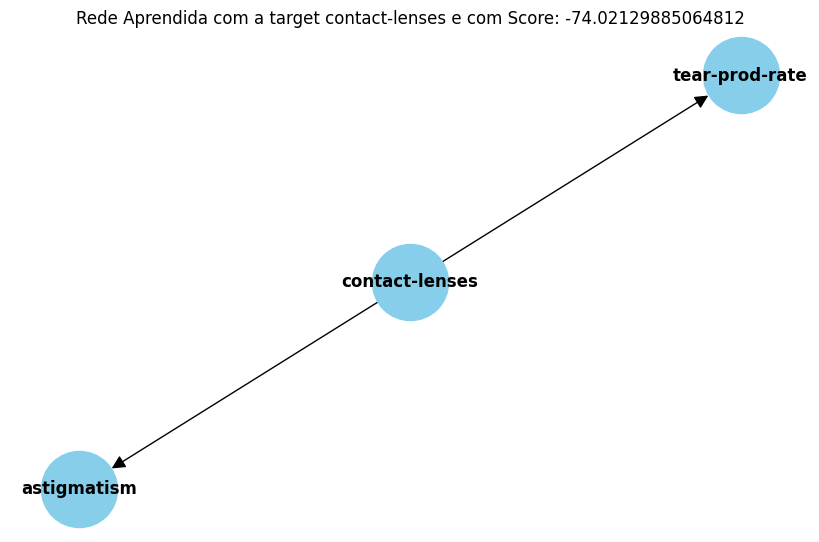

Tempo gasto: 0.40021347999572754


In [2]:
import pandas as pd
import sys
from pgmpy.estimators import K2Score
from sklearn.preprocessing import LabelEncoder
import time
import networkx as nx
import matplotlib.pyplot as plt

def load_data(DATA_CSV):
    D = pd.read_csv('teste.csv')
    D = D.apply(LabelEncoder().fit_transform)

    V = D.columns
    N = len(D.index)
    V_CARD = {v: len(D[v].unique()) for v in V}


    print(f'ARQUIVO: {D}')
    print(f'VARIÁVEIS: {V}')
    print(f'NÚMERO DE AMOSTRAS: {N}')
    print(f'MAPEAMENTO DAS VARIÁVEIS COM NÚMEROS DE VALORES ÚNICOS: {V_CARD}')
    return D, V, N, V_CARD

def predecessors(x, pa, ordering):
    pred = []
    x_idx = ordering.index(x)
    for y in ordering[:x_idx]:
        if y not in pa:
            pred.append(y)
    return pred

def K2_algorithm(ordering, max_parents, D):
    k2sc = K2Score(D).local_score
    PI = {v: [] for v in V}
    total_score = 0  # Inicializar o score total

    for x in V[1:]:
        proceed = True
        old_sc = k2sc(x, PI[x])
        while proceed and len(PI[x]) < max_parents[x]:
            proceed = False
            z, new_sc = None, None
            pred = predecessors(x, PI[x], ordering)
            if pred != []:
                z, new_sc = max([(y, k2sc(x, PI[x] + [y])) for y in pred], key=lambda t: t[1])
                if new_sc > old_sc:
                    old_sc = new_sc
                    PI[x].append(z)
                    proceed = True
        # Acumular o score total
        total_score += old_sc

    print("Score Total:", total_score)  # Imprimir o score total
    print("Rede: ", PI)
    #Guardar o PI no arquivo, para imprimir o desenho num arquivo para realizar as comparações
    #Deve ter uma função para realizar isso
    #Pesquisar: Comparar redes bayesianas com pgmpy ou bnlearn

    # Criar um grafo direcionado
    G = nx.DiGraph()
    for node, parents in PI.items():
        for parent in parents:
            G.add_edge(parent, node)

    # Desenhar o grafo
    plt.figure(figsize=(8, 5))
    pos = nx.spring_layout(G)
    nx.draw(G, pos, with_labels=True, node_size=3000, node_color="skyblue", font_size=12, font_weight="bold", arrowsize=20)
    plt.title(f"Rede Aprendida com a target {target_column} e com Score: {total_score}")
    plt.show()

    return PI, total_score


if __name__ == '__main__':
    DATA_CSV = sys.argv[1]
    #k = sys.argv[2]

    D, V, N, V_CARD = load_data(DATA_CSV)
    #Para passar as variáveis em ordem, selecionadas pelo Boruta, passamos como parâmetro a all_features
    V = list(all_features)
    print('Numero de variáveiss: ', len(V))
    print('Numero de amostras: ', N)
    print('Lista de variáveis de acordo com o Boruta: ', V)

    start_time = time.time()
    

    parents = int(len(V)) / 5
    max_parents = {v: parents for v in V}
    ordering = [v for v in V]

    PI = K2_algorithm(ordering, max_parents, D)

    final_time = time.time() - start_time

    print(f'Tempo gasto: {final_time}')




ARQUIVO:     age  spectacle-prescrip  astigmatism  tear-prod-rate  contact-lenses
0     2                   1            0               1               1
1     2                   1            0               0               2
2     2                   1            1               1               1
3     2                   1            1               0               0
4     2                   0            0               1               1
5     2                   0            0               0               2
6     2                   0            1               1               1
7     2                   0            1               0               0
8     0                   1            0               1               1
9     0                   1            0               0               2
10    0                   1            1               1               1
11    0                   1            1               0               0
12    0                   0            0  

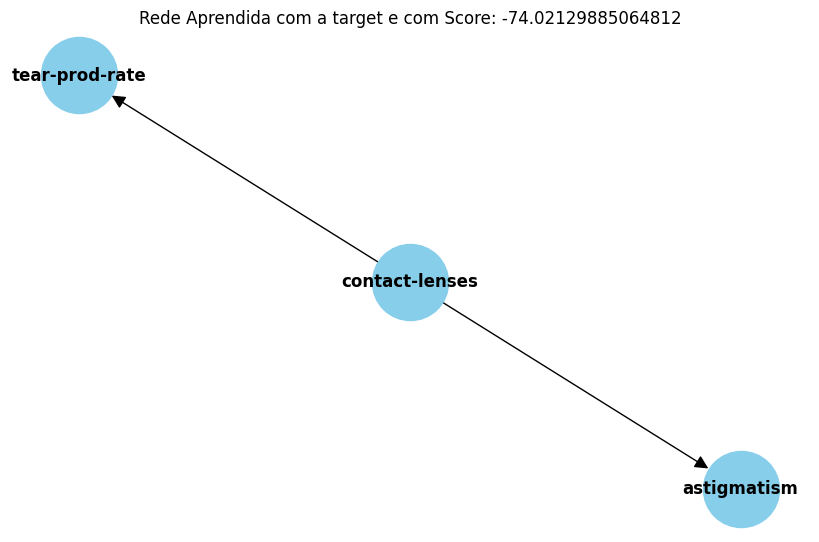

Tempo gasto: 0.371227502822876


In [18]:
import pandas as pd
import sys
from pgmpy.estimators import K2Score
from sklearn.preprocessing import LabelEncoder
import time
import networkx as nx
import matplotlib.pyplot as plt
import xml.etree.ElementTree as ET
import xml.dom.minidom as minidom

def load_data(DATA_CSV):
    D = pd.read_csv('teste.csv')
    D = D.apply(LabelEncoder().fit_transform)

    V = D.columns
    N = len(D.index)
    V_CARD = {v: len(D[v].unique()) for v in V}

    print(f'ARQUIVO: {D}')
    print(f'VARIÁVEIS: {V}')
    print(f'NÚMERO DE AMOSTRAS: {N}')
    print(f'MAPEAMENTO DAS VARIÁVEIS COM NÚMEROS DE VALORES ÚNICOS: {V_CARD}')
    return D, V, N, V_CARD

def predecessors(x, pa, ordering):
    pred = []
    x_idx = ordering.index(x)
    for y in ordering[:x_idx]:
        if y not in pa:
            pred.append(y)
    return pred

def K2_algorithm(ordering, max_parents, D):
    k2sc = K2Score(D).local_score
    PI = {v: [] for v in V}
    total_score = 0  # Inicializar o score total

    for x in V[1:]:
        proceed = True
        old_sc = k2sc(x, PI[x])
        while proceed and len(PI[x]) < max_parents[x]:
            proceed = False
            z, new_sc = None, None
            pred = predecessors(x, PI[x], ordering)
            if pred != []:
                z, new_sc = max([(y, k2sc(x, PI[x] + [y])) for y in pred], key=lambda t: t[1])
                if new_sc > old_sc:
                    old_sc = new_sc
                    PI[x].append(z)
                    proceed = True
        # Acumular o score total
        total_score += old_sc

    print("Score Total:", total_score)  # Imprimir o score total
    print("Rede: ", PI)

    # Criar XML
    root = ET.Element("BayesianNetwork")
    for node, parents in PI.items():
        node_elem = ET.SubElement(root, "NODE", NAME=node)
        for parent in parents:
            ET.SubElement(node_elem, "ARC", FROM=parent, TO=node)

    # Converter XML em uma string com formatação
    xml_str = minidom.parseString(ET.tostring(root)).toprettyxml(indent="  ")

    # Escrever XML em um arquivo
    with open("rede_bayesiana.xml", "w") as xml_file:
        xml_file.write(xml_str)

    # Criar um grafo direcionado
    G = nx.DiGraph()
    for node, parents in PI.items():
        for parent in parents:
            G.add_edge(parent, node)

    # Desenhar o grafo
    plt.figure(figsize=(8, 5))
    pos = nx.spring_layout(G)
    nx.draw(G, pos, with_labels=True, node_size=3000, node_color="skyblue", font_size=12, font_weight="bold", arrowsize=20)
    plt.title(f"Rede Aprendida com a target e com Score: {total_score}")
    plt.show()

    return PI, total_score

if __name__ == '__main__':
    DATA_CSV = sys.argv[1]
    # k = sys.argv[2]

    D, V, N, V_CARD = load_data(DATA_CSV)
    # Para passar as variáveis em ordem, selecionadas pelo Boruta, passamos como parâmetro a all_features
    V = list(all_features)
    print('Numero de variáveis: ', len(V))
    print('Numero de amostras: ', N)
    print('Lista de variáveis de acordo com o Boruta: ', V)

    start_time = time.time()

    parents = int(len(V)) / 5
    max_parents = {v: parents for v in V}
    ordering = [v for v in V]

    PI = K2_algorithm(ordering, max_parents, D)

    final_time = time.time() - start_time

    print(f'Tempo gasto: {final_time}')


In [19]:
#Visualizando as propriedades da rede

import networkx as nx
import xml.etree.ElementTree as ET

def ler_rede_bayesiana(arquivo_xml):
    # Cria um grafo direcionado
    grafo = nx.DiGraph()

    # Faz a leitura do arquivo XML
    tree = ET.parse(arquivo_xml)
    raiz = tree.getroot()

    # Itera sobre os nós
    for node in raiz.findall('.//NODE'):
        nome_no = node.attrib['NAME']
        grafo.add_node(nome_no)

    # Itera sobre as arestas
    for arc in raiz.findall('.//ARC'):
        origem = arc.attrib['FROM']
        destino = arc.attrib['TO']
        grafo.add_edge(origem, destino)

    return grafo

def mostrar_rede_bayesiana(grafo):
    print("Nós da rede:")
    print(list(grafo.nodes()))
    print("\nArestas da rede:")
    print(list(grafo.edges()))

# Exemplo de uso
arquivo_xml = "rede_bayesiana.xml"
rede_bayesiana = ler_rede_bayesiana(arquivo_xml)
mostrar_rede_bayesiana(rede_bayesiana)


Nós da rede:
['contact-lenses', 'tear-prod-rate', 'age', 'spectacle-prescrip', 'astigmatism']

Arestas da rede:
[('contact-lenses', 'tear-prod-rate'), ('contact-lenses', 'astigmatism')]
